In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from mydatools.features_analyze import get_top_k_corr

% matplotlib inline

In [2]:
# pc memory is small, can't compute svd
is_in_pc = True

In [3]:
train_text_df = pd.read_csv('./data/input/training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
train_variants_df = pd.read_csv('./data/input/training_variants')
train_df = train_variants_df.merge(train_text_df, how='left', on='ID')
train_df['train_or_test'] = 'train'

test_text_df = pd.read_csv('./data/input/test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_variants_df = pd.read_csv('./data/input/test_variants')
test_df = test_variants_df.merge(test_text_df, how='left', on='ID')
test_df['train_or_test'] = 'test'

full_df = pd.concat([train_df, test_df])

del(train_text_df)
del(train_variants_df)
del(train_df)
del(test_text_df)
del(test_variants_df)
del(test_df)

full_df.head()

,Class,Gene,ID,Text,Variation,train_or_test
0,1.0,FAM58A,0,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,train
1,2.0,CBL,1,Abstract Background Non-small cell lung canc...,W802*,train
2,2.0,CBL,2,Abstract Background Non-small cell lung canc...,Q249E,train
3,3.0,CBL,3,Recent evidence has demonstrated that acquired...,N454D,train
4,4.0,CBL,4,Oncogenic mutations in the monomeric Casitas B...,L399V,train


In [4]:
is_train = full_df['train_or_test'] == 'train'
is_test = full_df['train_or_test'] == 'test'

In [5]:
# replace null
full_df.loc[full_df['Text'] == 'null', 'Text'] = ''

## feature

In [6]:
feature_columns = []

def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

* Text length

In [7]:
full_df['text_nb_chars'] = full_df['Text'].str.len()
full_df['text_nb_words'] = full_df['Text'].apply(lambda x: len(x.split()))
add_features(['text_nb_chars', 'text_nb_words'])

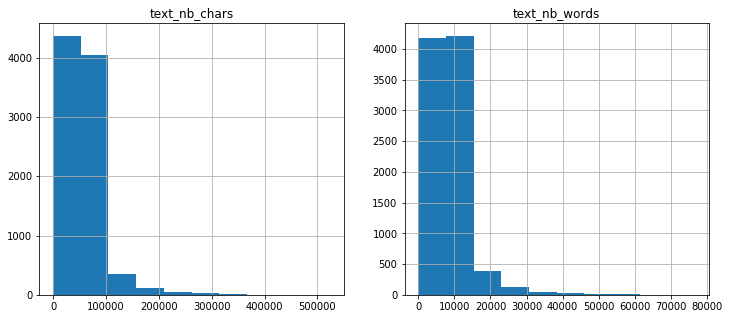

In [8]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

plt.subplot(121)
full_df['text_nb_chars'].hist()
plt.title('text_nb_chars')

plt.subplot(122)
full_df['text_nb_words'].hist()
plt.title('text_nb_words')

* text tfidf

In [9]:
%%time
tfidf_solver = TfidfVectorizer(stop_words='english', ngram_range=(1,1))
tfidf_solver.fit(full_df[is_train]['Text'])
text_tfidf_res = tfidf_solver.transform(full_df['Text'])

CPU times: user 1min 52s, sys: 1.69 s, total: 1min 54s
Wall time: 1min 55s


In [10]:
# dimensionality reduction
nb_dr_dim = 100
if not is_in_pc:
    dr_res = TruncatedSVD(nb_dr_dim).fit_transform(text_tfidf_res)
else:
    dr_res = TruncatedSVD(nb_dr_dim).fit_transform(text_tfidf_res[:, :(2*nb_dr_dim)])

In [11]:
feats = ['text_word_%03d'%i for i in range(nb_dr_dim)]
for f in feats: full_df[f] = 0
full_df[feats] = dr_res
add_features(feats)

* gene/variation labelencode

In [12]:
nb_dr_dim = 100
for feat in ['Gene', 'Variation']:
    # label dummy
    encode_res = pd.get_dummies(full_df[feat]).values
    
    # dimensionality reduction
    if not is_in_pc:
        dr_res = TruncatedSVD(nb_dr_dim).fit_transform(encode_res)
    else:
        dr_res = TruncatedSVD(nb_dr_dim).fit_transform(encode_res[:, :(2*nb_dr_dim)])
        
    # add features
    feats = [feat+'_encode_%03d'%i for i in range(nb_dr_dim)]
    for f in feats: full_df[f] = 0
    full_df[feats] = dr_res
    add_features(feats)

## LightGBM

In [13]:
trn_df = full_df[is_train]
tst_df = full_df[is_test]

X = trn_df[feature_columns]
y = trn_df['Class']
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns]

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

In [24]:
params = {
    'application': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 10,
    'learning_rate': 0.1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)

[1]	training's multi_logloss: 2.0233	valid_1's multi_logloss: 2.07094
Train until valid scores didn't improve in 20 rounds.
[2]	training's multi_logloss: 1.9031	valid_1's multi_logloss: 1.97976
[3]	training's multi_logloss: 1.80043	valid_1's multi_logloss: 1.90523
[4]	training's multi_logloss: 1.71313	valid_1's multi_logloss: 1.84306
[5]	training's multi_logloss: 1.63574	valid_1's multi_logloss: 1.78697
[6]	training's multi_logloss: 1.56714	valid_1's multi_logloss: 1.73947
[7]	training's multi_logloss: 1.50622	valid_1's multi_logloss: 1.69946
[8]	training's multi_logloss: 1.44898	valid_1's multi_logloss: 1.66194
[9]	training's multi_logloss: 1.39832	valid_1's multi_logloss: 1.62904
[10]	training's multi_logloss: 1.35145	valid_1's multi_logloss: 1.60084
[11]	training's multi_logloss: 1.30752	valid_1's multi_logloss: 1.57343
[12]	training's multi_logloss: 1.26765	valid_1's multi_logloss: 1.54775
[13]	training's multi_logloss: 1.23063	valid_1's multi_logloss: 1.5257
[14]	training's multi_

In [25]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model=bst, 
                learning_rates=lambda iter: 0.1 * (0.99 ** iter))

[56]	training's multi_logloss: 0.712063	valid_1's multi_logloss: 1.38178
Train until valid scores didn't improve in 20 rounds.
[57]	training's multi_logloss: 0.698787	valid_1's multi_logloss: 1.37467
[58]	training's multi_logloss: 0.686828	valid_1's multi_logloss: 1.37
[59]	training's multi_logloss: 0.676638	valid_1's multi_logloss: 1.36574
[60]	training's multi_logloss: 0.667235	valid_1's multi_logloss: 1.36196
[61]	training's multi_logloss: 0.658267	valid_1's multi_logloss: 1.36008
[62]	training's multi_logloss: 0.649874	valid_1's multi_logloss: 1.35789
[63]	training's multi_logloss: 0.642412	valid_1's multi_logloss: 1.35781
[64]	training's multi_logloss: 0.635349	valid_1's multi_logloss: 1.35683
[65]	training's multi_logloss: 0.628524	valid_1's multi_logloss: 1.35609
[66]	training's multi_logloss: 0.622139	valid_1's multi_logloss: 1.35459
[67]	training's multi_logloss: 0.615875	valid_1's multi_logloss: 1.3525
[68]	training's multi_logloss: 0.610338	valid_1's multi_logloss: 1.35359
[

In [ ]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

## predict

In [ ]:
res_df = pd.DataFrame({
    'ID': tst_df['ID'],
    'Class': bst.predict(X_tst),
})
res_df.to_csv('./data/output/submission.csv', index=False)